In [51]:
import numpy as np
%pylab
%matplotlib inline

from Functions import image_processing as ip
from Functions import seed_detection as sd
from Functions import seeded_region_growing as srg
import skimage.io as sk

# from collections import Counter

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [52]:
image = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Bild laden
image_resize = ip.img_resize(image, 500, 500)

In [53]:
#seed_final = sd.seeds(image_resize, 0.4, 40)
#ip.show_image(seed_final, 15, 8)

In [54]:
#test = sd.seed_merging(seed_final)
#ip.show_image(test, 15, 8)

In [55]:
#test2 = sd.decrease_region_number(test, 10)
#ip.show_image(test2, 15, 8)

In [56]:
#test3 = sd.decrease_region_number(test, 50)
#ip.show_image(test3, 15, 8)

# end of automatic seed detection

In [58]:
def find_neighbors2(list_pos_region, reg):
    neighbors = []
    for p in list_pos_region:
        if reg[p] != 0: # Pixels with region
            if p[0] > 0: # Add neighbours to list T, left
                a = (p[0]-1, p[1])
                if reg[a] == 0 and a not in neighbors:
                    neighbors.append(a)
            if p[0] < reg.shape[0]-1: # Add neighbours to list T, right
                b = (p[0]+1, p[1])
                if reg[b] == 0 and b not in neighbors:
                    neighbors.append(b)
            if p[1] > 0: # Add neighbours to list T, up
                c = (p[0], p[1]-1)
                if reg[c] == 0 and c not in neighbors:
                    neighbors.append(c)
            if p[1] < reg.shape[1]-1: # Add neighbours to list T, down
                d = (p[0], p[1]+1)
                if reg[d] == 0 and d not in neighbors:
                    neighbors.append(d)
    return neighbors




In [60]:
# calculated mean value of region of newly labeled pixel
def one_region_mean(img, reg, new_pixel): #img is array of intensity values, regions is array with region numbers, new_pixel is position of last added pixel
    intensity = []
    for p in np.ndindex(img.shape):
        if reg[p] == reg[new_pixel]: # finds region of newly added pixel
            intensity.append(img[p]) #iterates over every pixel in the image and appends intensity value, if it is in the region
    single_mean = np.mean(intensity) #calculates mean value of region with new pixel
    return single_mean #returns mean value of changed region

In [61]:
# calculated mean value of region of newly labeled pixel
def one_region_mean2(img, reg, new_pixel): #img is array of intensity values, regions is array with region numbers, new_pixel is position of last added pixel
    pos_new_reg = np.where(reg == reg[new_pixel])
    single_mean = np.mean(img[pos_new_reg[0],pos_new_reg[1]])
    return single_mean #returns mean value of changed region

In [62]:
y = np.zeros((3,3))
y[(0,1)] = 1
y[(1,1)] = 1
y[(2,2)] = 1
print(y)
pos = np.where(y==1)
rows = pos[0]
cols = pos[1]
pos = list(zip(pos[0], pos[1]))
a = y[rows,cols]
print(a)
print(pos)
print(pos[0])
print(pos[0][0])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[1. 1. 1.]
[(0, 1), (1, 1), (2, 2)]
(0, 1)
0


In [63]:
def calculation_distance(img, neighbors, reg): # img intensity values, regions is region number, Ne is list of neighbours
    max_intensity = np.amax(img)
    means = srg.mean_region(img, reg) # list of mean values of every region
    result = np.ones(img.shape) # new array with distance values, standard value is one
    nearest_reg = np.zeros(img.shape)
    for i in neighbors:
        nei = srg.add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        for j in nei:
            if reg[j] != 0: # only neighboring pixels which are sorted
                distance.append(np.abs((img[i] - means[int(reg[j]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                region_number.append(reg[j])
        min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
        pos_min_dist = distance.index(min(distance))
        nearest_reg[i] = region_number[int(pos_min_dist)] # saves number of nearest region
        result[i] = min_dist
    return result, nearest_reg, means  # returns array with distance values between 0 and 1 and array with number of nearest region


In [64]:
def calculation_distance2(img, neighbors, reg): # img intensity values, regions is region number, Ne is list of neighbours
    distances = np.ones((img.shape[0],img.shape[1],5))
    regions_with_border = np.zeros((img.shape[0]+2, img.shape[1]+2))
    regions_with_border[1:img.shape[0]+1, 1:img.shape[1]+1] = reg
    #distances[,1]
    max_intensity = np.amax(img)
    means = srg.mean_region(img, reg) # list of mean values of every region
    result = np.ones(img.shape) # new array with distance values, standard value is one
    nearest_reg = np.zeros(img.shape)
    for i in neighbors:
        nei = srg.add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        for j in nei:
            if reg[j] != 0: # only neighboring pixels which are sorted
                distance.append(np.abs((img[i] - means[int(reg[j]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                region_number.append(reg[j])
        min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
        pos_min_dist = distance.index(min(distance))
        nearest_reg[i] = region_number[int(pos_min_dist)] # saves number of nearest region
        result[i] = min_dist
    return result, nearest_reg, means  # returns array with distance values between 0 and 1 and array with number of nearest region




In [65]:
# Idee: veränderte Region: nur Nachbarn dieser Region werden betrachtet

def new_distance(img, reg, nearest_reg, dis, new_pixel, neighbors, means):
    new_mean = one_region_mean2(img, reg, new_pixel)
    means[int(reg[new_pixel] -1)] = new_mean # list of all mean values of the region with the updated region
    max_intensity = np.amax(img)
    for i in neighbors:
        nei = srg.add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        counter = 0
        for j in nei:
            if counter == 0:
                if reg[j] == reg[new_pixel]: # calculates distance only for pixel adjacent to updated region
                    counter = 1
                    for k in nei:
                        if reg[k] != 0: # compare all neighboring regions
                            distance.append(np.abs((img[i] - means[int(reg[k]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                            region_number.append(reg[k])
                    min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
                    # only calculates new distances once
                    pos_min_dist = distance.index(min_dist)
                    nearest_reg[i] = region_number[int(pos_min_dist)] # saves number of nearest region # saves number of nearest region
                    dis[i] = min_dist
    return dis, nearest_reg, means  # returns array with distance values between 0 and 1 and array with number of nearest region

In [66]:
def new_distance2(img, reg, nearest_reg, dis, new_pixel, neighbors, means):
    new_mean = one_region_mean2(img, reg, new_pixel)
    means[int(reg[new_pixel] -1)] = new_mean # list of all mean values of the region with the updated region
    max_intensity = np.amax(img)
    pos_new_reg = np.where(reg == reg[new_pixel])
    pos_new_reg = list(zip(pos_new_reg[0], pos_new_reg[1]))
    nei_region = find_neighbors2(pos_new_reg, reg)
    for i in nei_region:
        nei = srg.add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        for j in nei:
            if reg[j] != 0: # only neighboring pixels which are sorted
                distance.append(np.abs((img[i] - means[int(reg[j]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                region_number.append(reg[j])
        min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
        pos_min_dist = distance.index(min(distance))
        nearest_reg[i] = region_number[int(pos_min_dist)] # saves number of nearest region
        dis[i] = min_dist
    return dis, nearest_reg, means  # returns array with distance values between 0 and 1 and array with number of nearest region



# Region add nei, speichern die keine Region haben

In [67]:
def label(reg, dis, nearest_reg, neighbors): # regions is array of region numbers, distances is array of distances, nearest_reg is array of nearest region number
    x = np.where(dis == np.amin(dis)) #finds minimal distance in array and its position
    #print(distances)
    pos_min_dist = list(zip(x[0], x[1]))[0] # position of first pixel with minimal distance value
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1])) #converting to int for finding in list
    reg[pos_min_dist] = nearest_reg[pos_min_dist]
    #print(pos_min_dist)
    #print(Ne)
    neighbors.remove(pos_min_dist) #removes newly labeled entry from list Ne
    dis[pos_min_dist] = 1
    print(len(neighbors))
    return reg, pos_min_dist, neighbors, dis # returns new labeled region array and position of newly labeled pixel

In [73]:
def region_growing(img, reg):
    neighbors = srg.find_neighbors(reg) #list of all adjacent pixels
    dist = calculation_distance(img, neighbors, reg) #array of smallest distances
    regions_new = label(reg, dist[0], dist[1], neighbors) #labels pixel with smallest distance
    neighbors = regions_new[2]
    distances = regions_new[3]
    neighbors_add = srg.add_neighbors(img, regions_new[1]) #finds neighbors of newly labeled pixel
    for j in neighbors_add: #updates list of adjacent pixels
        if j not in neighbors and reg[j] == 0:
            neighbors.append(j)
    while len(neighbors)>0: #as long as not all pixels are sorted
        dist = new_distance2(img, regions_new[0], dist[1], distances, regions_new[1], neighbors, dist[2]) #updates distances
        regions_new = label(regions_new[0], dist[0], dist[1], neighbors) #labels next pixel
        neighbors = regions_new[2]
        distances = regions_new[3]
        neighbors_add = srg.add_neighbors(img, regions_new[1]) #finds neighbors of newly labeled pixel
        for j in neighbors_add: #updates Ne
            if j not in neighbors and reg[j] == 0:
                neighbors.append(j)
    return regions_new[0] #returns array with region numbers


C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:41: RuntimeWarning: invalid value encountered in double_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list


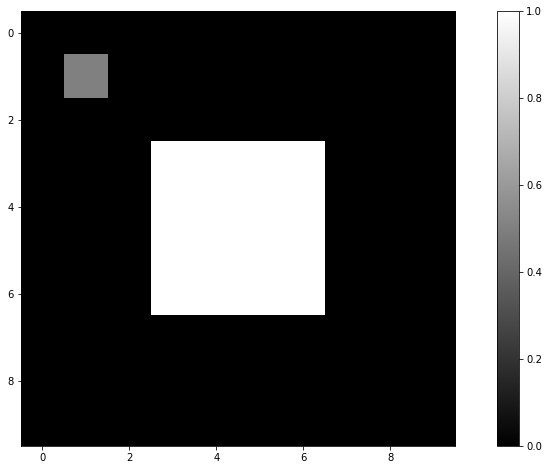

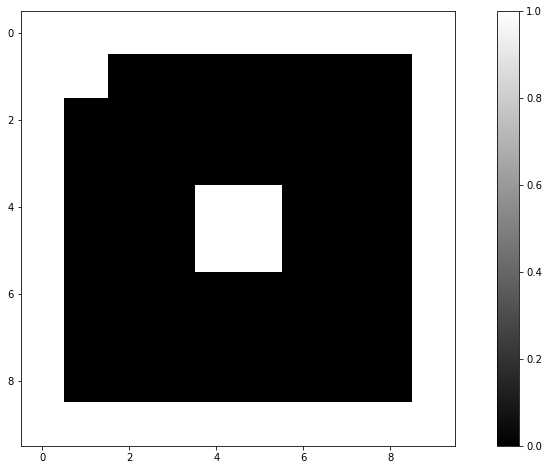

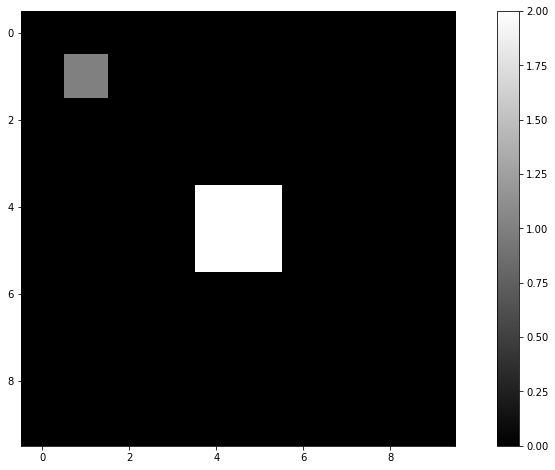

In [69]:
#img_n = np.zeros([10, 10])
#img_n[3:7, 3:7] = 1
#img_n[1:2, 1:2] = 0.5
#ip.show_image(img_n,15,8)

#img_t = sd.seeds(img_n, 0.4, 40)
#ip.show_image(img_t,15,8)

#img_t = sd.seed_merging(img_t)
#ip.show_image(img_t,15,8)

11
12
13
14
15
15
15
16
17
18
18
18
19
20
19
19
20
21
22
23
24
25
25
25
25
24
23
22
21
21
21
21
21
21
20
19
18
17
16
15
15
15
15
15
14
13
13
13
13
13
12
11
11
11
11
11
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
8
7
6
5
4
3
2
1
0


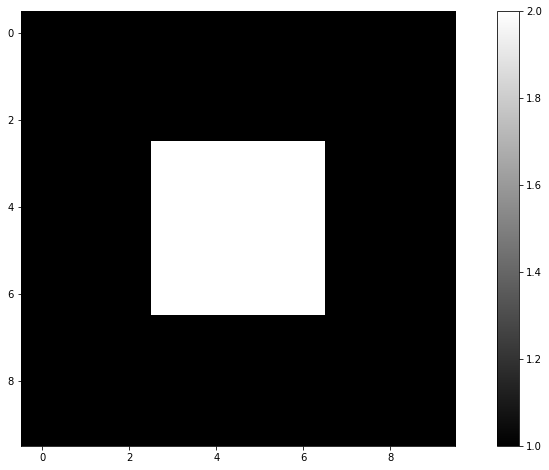

In [70]:
#img_t = region_growing(img_n, img_t)
#ip.show_image(img_t, 15,8)


C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:41: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:41: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:41: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list


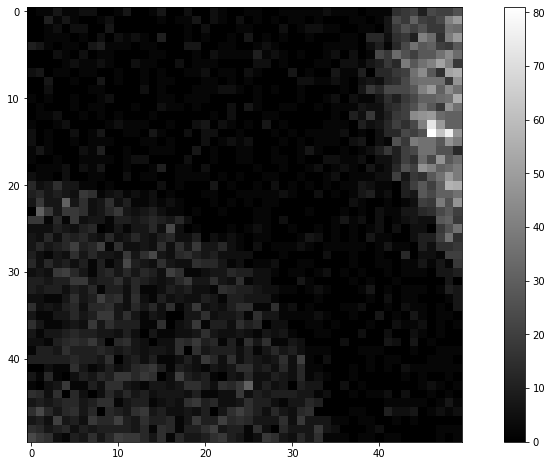

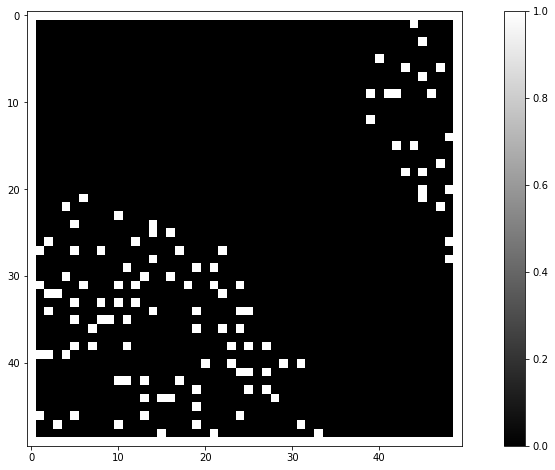

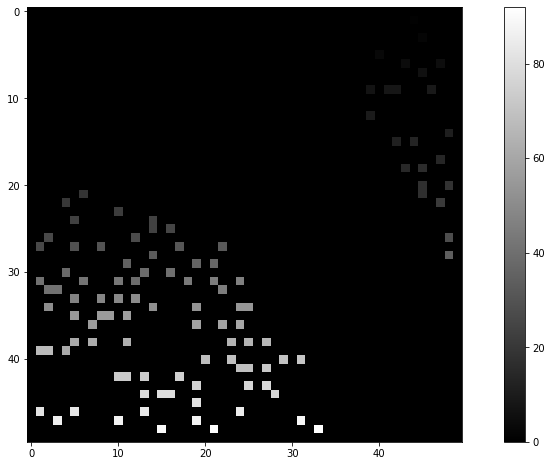

In [74]:
img_small = image[300:350, 400:450]
ip.show_image(img_small, 15, 8)
img_r = sd.seeds(img_small, 0.1, 1)
ip.show_image(img_r, 15, 8)
img_r = sd.seed_merging(img_r)
ip.show_image(img_r, 15, 8)

366
368
368
368
368
369
370
371
370
369
368
368
369
370
371
372
372
372
373
373
374
374
375
376
375
375
375
374
376
378
379
379
379
380
381
380
380
382
381
382
382
382
381
381
380
382
381
380
380
379
379
379
379
378
378
377
376
375
375
374
373
373
373
375
376
376
375
375
374
373
373
373
373
374
373
373
373
375
377
377
376
376
375
375
377
379
378
377
377
379
378
378
380
380
379
378
378
377
377
376
375
376
375
374
373
372
372
372
371
373
372
372
373
373
374
374
374
374
373
373
373
372
373
375
376
375
375
375
374
373
374
375
374
375
374
375
375
376
376
376
378
379
380
382
382
382
381
383
384
386
387
388
387
387
388
389
390
391
393
392
394
396
397
397
397
396
395
394
394
394
393
394
393
392
391
391
390
389
388
387
386
385
385
385
387
386
387
387
388
387
386
386
385
384
384
383
383
384
384
383
383
384
385
385
384
384
385
385
385
386
387
386
386
385
386
386
387
386
385
384
384
383
384
386
386
387
388
390
389
389
390
389
389
388
387
386
387
386
386
386
387
386
386
385
385
385
385
385
385
387


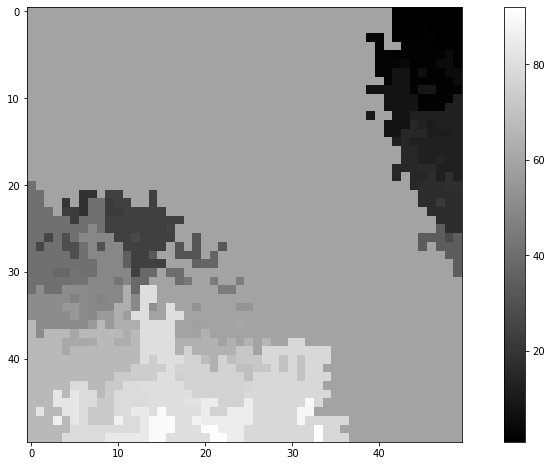

In [75]:
img_r = region_growing(img_small, img_r)
ip.show_image(img_r, 15, 8)


In [ ]:
#region-merging

def region_distance(img, reg):
    max_region = max(reg.flatten())
    inter_region_distances = np.ones((int(max_region), int(max_region)))
    means = srg.mean_region(img, reg)
    for row_number in range(0, int(max_region)):
        for col_number in range(0, int(max_region)):
            if col_number > row_number:
                distance = abs(means[row_number] - means[col_number]) / (np.amax(img))
                inter_region_distances[row_number][col_number] = distance
    return inter_region_distances, means

In [ ]:
def one_merged_region_mean(img, reg, region_number): #img is array of intensity values, regions is array with region numbers, new_pixel is position of last added pixel
    pos_new_reg = np.where(reg == region_number)
    single_mean = np.mean(img[pos_new_reg[0],pos_new_reg[1]])
    return single_mean #returns mean value of changed region


In [ ]:
def region_distance_new(img, reg, pos_min_dist, means, inter_region_distances):
    region_number = inter_region_distances.shape[0]
    maximal_intensity = np.amax(img)
    changed_region1 = int(pos_min_dist[0]) # Regions Nummer 1 die übernommen wird
    changed_region2 = int(pos_min_dist[1])
    means = update_mean_values(means, changed_region1, changed_region2, img, reg)
    inter_region_distances = update_distances(changed_region1, changed_region2, inter_region_distances, region_number, means, maximal_intensity)
    return inter_region_distances

def update_distances(changed_region1, changed_region2, inter_region_distances, region_number, means, maximal_intensity):
    for col_number in range(changed_region1 + 1, int(region_number)+1): # Regions Nummer 2, die nicht übernommen wird
        distance = abs(means[changed_region1] - means[col_number]) / maximal_intensity
        inter_region_distances[changed_region1][col_number] = distance
    for row_number in range(0, changed_region1):
        distance = abs(means[changed_region1] - means[row_number]) / maximal_intensity
        inter_region_distances[row_number][changed_region1] = distance
    inter_region_distances[changed_region2][0:region_number] = 500
    inter_region_distances[0:region_number][changed_region2] = 500
    return inter_region_distances

def update_mean_values(means, changed_region1, changed_region2, img, reg):
    means[changed_region2] = 500
    means[changed_region1] = one_merged_region_mean(img, reg, changed_region1)
    return means

In [ ]:
def region_merge_by_distance(inter_region_distances, reg, min_distance):
    x = np.where(inter_region_distances == min_distance) #finds minimal distance in array and its position
    pos_min_dist = list(zip(x[0], x[1]))[0] # position of first pixel with minimal distance value
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1])) #converting to int for finding in list
    pixel_to_change = np.where(reg == pos_min_dist[1]) #zu ändernde Region ist immer die Spalte in inter_region_distances (Spaltenzahl immer größer Zeilenzahl)
    pixel_to_change_rows = pixel_to_change[0]
    pixel_to_change_cols = pixel_to_change[1]
    reg[pixel_to_change_rows, pixel_to_change_cols] = pos_min_dist[0]
    return reg, pos_min_dist

In [ ]:
def distance_merging_while(reg, t, img):
    result_region_distance = region_distance(img, reg)
    inter_region_distances = result_region_distance[0]
    means = result_region_distance[1]
    min_distance = np.amin(inter_region_distances)
    print(inter_region_distances[0][1])
    print(min_distance)
    print(inter_region_distances)
    while min_distance < t:
        print(1)
        updated_regions = region_merge_by_distance(inter_region_distances, reg, min_distance)
        regions = updated_regions[0]
        pos_min_dist = updated_regions[1]
        inter_region_distances = region_distance_new(img, regions, pos_min_dist, means, inter_region_distances)
        min_distance = np.amin(inter_region_distances)
    return reg


In [ ]:
#test = distance_merging_while(img_r, 1, img_small)
#print(test)
#f.show_image(test, 15, 8)